<a href="https://colab.research.google.com/github/FranciscoOssian/ProdutoEducacional-ART-2/blob/main/RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

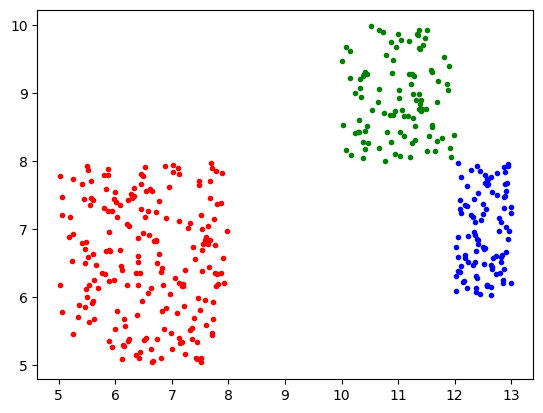

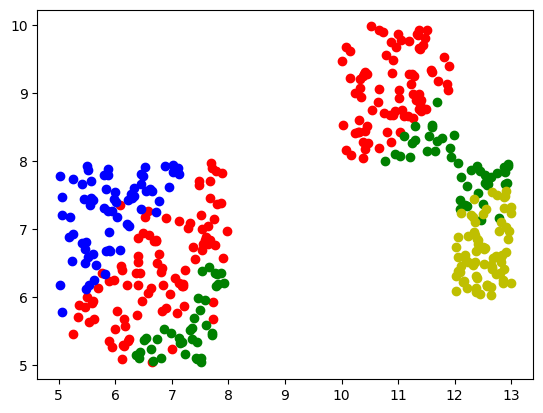

In [27]:
# https://github.com/ASTARCHEN/ART2py/blob/master/ART2.py


import numpy as np
import warnings
import math
import matplotlib.pyplot as plt


def Schema_ART2_F1(I, F2_feedback, a, b, theta, e, m):

    u = np.zeros((1,m))
    p = np.zeros((1,m))
    # x = np.zeros(m)
    # w = np.zeros(m)
    # q = np.zeros(m)
    # v = np.zeros(m)
    temp = np.ones((1,m))

    while np.sum(abs(temp-u)) >= 0.001:
        temp = u[:]
        w = I + a * u
        p = u + F2_feedback
        x = w / (e + np.linalg.norm(w, 2))
        q = p / (e + np.linalg.norm(p, 2))
        x[x<theta] = 0 # 反映 f(x(k))
        q[q<theta] = 0 # 反映 f(q(k))
        v = x + b * q
        u = v /(e + np.linalg.norm(v, 2))
    return u,p


def ART_Process(I, NumNeurons, a, b, c, d, WF1_F2, WF2_F1, rho, theta, e):

    #  输入：     I - -----  待学习向量
    #  NumNeurons - -----  F2层神经元个数
    #  a, b, c, d - -----  ART2网络参数 （详见原始论文）
    #  WF1_F2 - -----  F1到F2层连接矩阵
    #  WF2_F1 - -----  F2到F1层连接矩阵
    #  rho - -----  警戒值
    #  theta, e - -----  ART2网络参数  （详见原始论文）
    #  输出：       u - ----- 用于WF1_F2, WF2_F1的学习（详见原始论文）
    #  J - ----- 本次训练胜出的神经元编号
    #
    #  使用说明： 在一个M文件中初始化NumNeurons，a, b, c, d,
    #  WF1_F2, WF2_F1，rho, theta, e等值，将输入向量放入Iput,
    #  调用ART_Process，将返回的u, J用于WF1_F2, WF2_F1的学习，学习算法可以自行选择

    y = np.zeros(NumNeurons)
    Counter = 1
    F2_feedback = 0
    m = len(I)
    while Counter > 0:
        u, p = Schema_ART2_F1(I, F2_feedback, a, b, theta, e, m)

        y[abs(y+1)>e] = (np.dot(WF1_F2[list(abs(y + 1) > e), :], np.transpose(p))).flatten()
        maxV = np.max(y)
        Js = np.where(y == maxV)
        J = Js[0][0]
        if abs(maxV+1) < e:
            print('分类数目已经超过最大神经元数目')
            raise
        F2_feedback = d * np.transpose(WF2_F1[:, J])
        p = u + F2_feedback
        r = (u + c * p) / (e + np.linalg.norm(u, 2) + c * np.linalg.norm(p, 2))
        R = np.linalg.norm(r, 2)
        if R < rho - e:
            y[J]= -1
            Counter = 1
        elif Counter == 1:
            Counter += 1
        else:
            # 快速学习
            WF2_F1[:, J] = np.transpose((u / (1 - d))[0])
            WF1_F2[J, :] = (u / (1 - d))[0]; # 在外部进行学习，返回u
            Counter = 0
    return u,J


def ART2(X, a=10, b=10, c=0.3, d=0.75, theta=0.1, rho=0.997, output=None, e=1E-8):
    if a <= 0:
        print('a should > 0, but a is ', str(a))
        raise
    if b <= 0:
        print('b should > 0, but  is ', str(b))
        raise
    if d < 0 or d > 1:
        print('0 <= d <= 1, but d is ', str(d))
        raise
    if c * d / (1 - d) > 1:
        print('c*d/(1-d) <= 1, but c*d/(1-d) is ', str(c * d / (1 - d)))
    if rho <= 0 or rho > 1:
        print('0 < rho <= 1, but rho is ', str(rho))
        raise
    if e > 1E-1:
        warnings('e << 1, but e is ', str(e))
    X = np.array(X)
    m, n = X.shape
    if output is None:
        output = m
    WF1_F2 = np.dot(np.ones((output,n)),0.5/((1-d)*math.sqrt(n)))
    WF2_F1 = np.zeros((n, output))

    w = np.zeros(m)
    for j in range(m):
        Input = X[j,:]
        u,J = ART_Process(Input, output,a,b,c,d,WF1_F2,WF2_F1, rho,theta,e)
        WF2_F1[:,J] = np.transpose((u/(1-d))[0])
        WF1_F2[J,:] = (u/(1-d))[0]
        w[j] = J
    return w

if __name__ == '__main__':
    # 训练x
    x1 = np.random.random((200, 2))*3 + 5
    x2 = np.hstack((np.random.random((100, 1))+2, np.random.random((100, 1))*2-4))+10
    x3 = np.hstack((np.random.random((100, 1))*2, np.random.random((100, 1))*2-2))+10
    x = np.vstack((x1,x2,x3))
    # 训练结果y
    y = np.zeros(400)
    # y[0:200] = 0
    y[200:300] = 1
    y[300:400] = 2

    e = 1E-6
    m, n = x.shape

    # 随机顺序
    ind = np.random.permutation(m)
    nx = x[ind,:]
    ny = y[ind]
    # ART2训练
    w = ART2(x,output=4, rho=0.9987)


    plt.figure(1)
    color_list_point = ['r.','b.','g.','y.','k.']
    color_list_circle = ['ro', 'bo', 'go', 'yo', 'ko']

    for j in range(int(max(y))+1):
        plt.plot(x[abs(y-j)<e,0], x[abs(y-j)<e,1],color_list_point[j])
    plt.figure(2)
    for j in range(int(max(w))+1):
        plt.plot(x[abs(w-j)<e, 0], x[abs(w-j)<e, 1], color_list_circle[j])
    plt.show()




In [28]:
# Célula 1: Importações
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans # Importando KMeans
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder

In [29]:
# Célula 2: Upload do dataset
uploaded = files.upload()

original_name = list(uploaded.keys())[0]
!mv './{original_name}' ./dataset.csv

print(f"Arquivo '{original_name}' renomeado para 'dataset.csv'.")

Saving treino - agro.csv to treino - agro.csv
Arquivo 'treino - agro.csv' renomeado para 'dataset.csv'.


In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("/content/dataset.csv")

# Separa os exemplos com target 0 e target 1
df_target_0 = df[df['target'] == 0]
df_target_1 = df[df['target'] == 1]

# Calcula a quantidade de exemplos da classe minoritária (target 1)
n_target_1 = len(df_target_1)

# Amostra a mesma quantidade da classe majoritária (target 0)
# random_state garante reprodutibilidade da amostragem
df_target_0_sampled = df_target_0.sample(n=n_target_1, random_state=42)

# Concatena os DataFrames balanceados
df_balanced = pd.concat([df_target_0_sampled, df_target_1])

# Embaralha o DataFrame (frac=1 embaralha todos os dados)
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Atualiza o DataFrame original com a versão balanceada
df = df_balanced

# --------------------------------

# Separar features e target
X = df.drop(['target', 'id'], axis=1)
y = df['target']

# Selecionar apenas colunas numéricas
numeric_cols = X.select_dtypes(include=np.number).columns

# Criar e aplicar o MinMaxScaler
#scaler = MinMaxScaler()
#X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Reconstruir o DataFrame
df = pd.concat([X, y], axis=1)

X = df.drop('target', axis=1)
y = df['target']

df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,target
151,6.747288,17.852938,34.637269,10.255481,3.230088,4.605235,37.662125,6.382331,4.923717,6.464337,19.407577,51.843093,2.284378,3.951406,4.010997,1
792,4.939515,15.330047,32.510721,11.639046,3.525211,4.231745,36.056646,3.868398,5.684737,5.550828,14.488457,59.856068,2.836055,3.162183,5.415523,0
3508,4.679410,25.774880,16.318410,7.523581,3.873071,3.419546,56.166324,3.911442,7.513222,9.332778,15.438085,79.108662,3.170610,3.555770,9.288120,1
1020,7.309584,13.263604,30.939915,8.813879,3.186495,4.615570,29.861707,4.791860,3.822610,4.802593,10.312666,40.249247,3.552598,2.864953,5.510535,0
2463,6.352333,11.594860,37.213208,8.953123,2.476322,4.142149,22.146926,2.765641,6.146879,4.198361,17.379483,64.722079,2.787429,4.257736,4.018361,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,6.411437,14.192588,36.237821,6.032740,2.125724,4.715767,39.236932,2.158834,7.334085,5.138967,21.225576,77.222484,3.075363,2.707326,5.270491,0
3966,5.962736,15.758141,35.078822,9.653213,3.039266,3.625057,35.233848,4.609698,5.774999,5.705836,13.643363,60.806462,2.636084,2.453690,3.945009,0
278,4.919437,12.821207,34.219014,8.313671,3.023938,3.945336,26.307636,4.481329,5.470200,4.642407,10.111121,57.597148,3.829723,1.877052,4.190249,0
1724,6.778462,18.671500,44.552225,10.669363,3.753388,4.912152,31.381054,4.598371,4.740321,6.760728,18.941044,49.912063,3.392398,3.269149,3.734457,1


In [31]:
def plot_heatmap(y, title):
    """Plota um heatmap para visualização de clusters ou target."""

    num_samples = len(y)
    data = np.zeros((num_samples, 2))
    data[:, 0] = y
    data[:, 1] = np.arange(num_samples)

    plt.figure(figsize=(8, 4)) # Ajuste o tamanho se necessário
    plt.imshow(data[:, 0].reshape(1, -1), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.yticks([])
    plt.xlabel('Índice do Item')
    if title == 'Dados Originais (Target)':
        plt.colorbar(label='Target (0 ou 1)')
    else:
        plt.colorbar(label='Cluster')
    plt.tight_layout()
    plt.show()

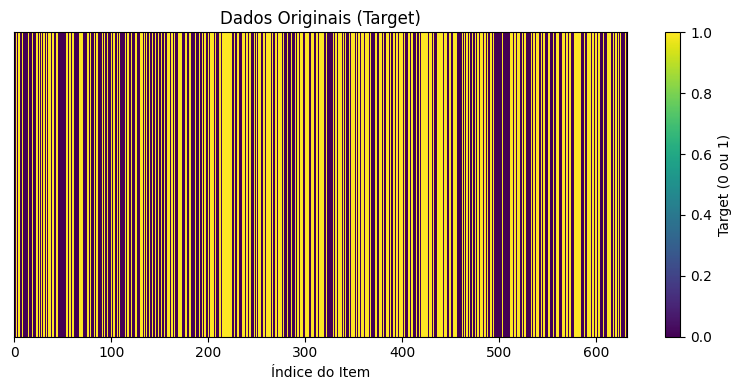

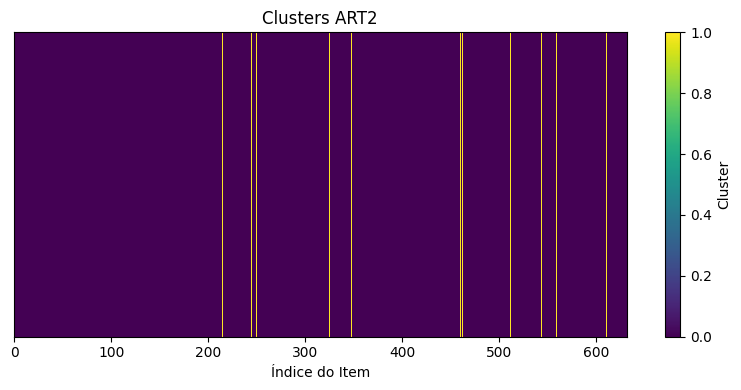

In [32]:
w = ART2(X.values, output=2, rho=0.97)

plot_heatmap(y, 'Dados Originais (Target)')
plot_heatmap(w, 'Clusters ART2')

In [33]:
X.values

array([[ 6.74728817, 17.85293847, 34.63726899, ...,  2.28437789,
         3.95140594,  4.01099685],
       [ 4.93951505, 15.33004711, 32.5107211 , ...,  2.83605479,
         3.16218336,  5.41552269],
       [ 4.67940962, 25.77487961, 16.31841045, ...,  3.17060981,
         3.55576996,  9.28812012],
       ...,
       [ 4.91943702, 12.82120667, 34.21901417, ...,  3.82972264,
         1.87705157,  4.19024921],
       [ 6.77846203, 18.67149977, 44.5522253 , ...,  3.39239807,
         3.26914915,  3.73445741],
       [ 5.14334876, 24.79157519, 39.49785018, ...,  1.75909811,
         4.43326743,  4.56371079]])

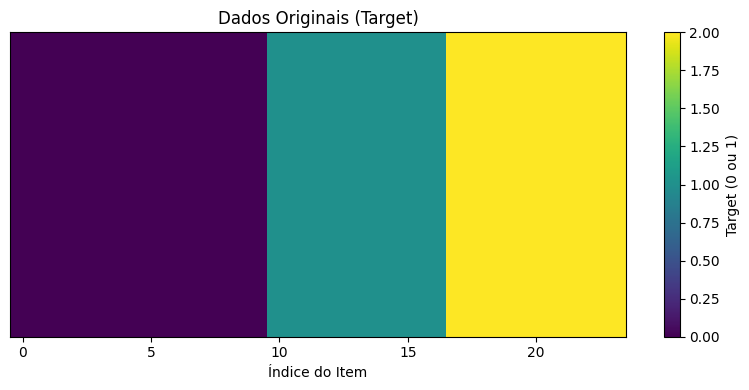

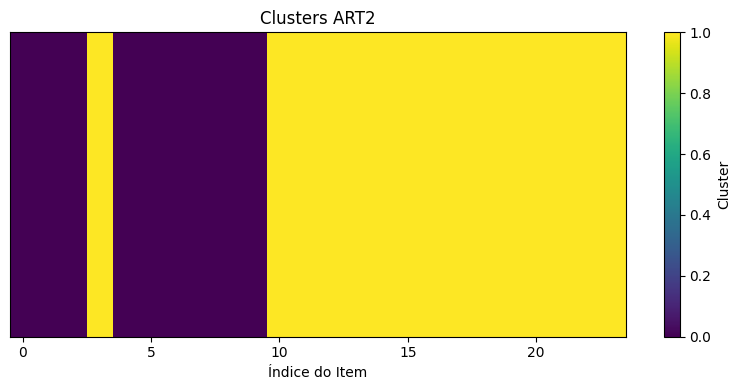

In [34]:
A=[1.1113447156646,5.2128918176852]
B=[0.8884528979794,4.7265823972811]
C=[1.5166025660014,4.8481597523821]
L=[6.1568049523573,3.3284428136193]
M=[1.2329220707657,4.1997471918433]
N=[0.6047724027437,4.4631647945622]
O=[2.2055409115739,4.6455308272138]
W=[0.6047724027437,3.6931748789224]
V=[2,4]
Z=[0.2400403374406,5.0710515700674]

D=[1.1113447156646,0.7550554639808]
Q=[2.3879069442254,0.2890089360935]
E=[2.7729019020454,0.4713749687451]
F=[1.9218604163382,0.6740038939135]
J=[1.435550995934,0.2687460435767]
K=[1.5368654585182,1.2818906694186]
P=[2.5297471918433,1.0387359592166]

G=[5.447603714268,4.2807987619107]
H=[5.4678666067848,3.6323862013718]
I=[6.318908092492,3.8552780190571]
R=[5.954176027189,2.983973640833]
S=[4.819454046246,3.9971182666749]
T=[5.2044490040659,3.3487057061361]
U=[4.3736704108756,3.4702830612371]

X = np.array([A,B,C,L,M,N,O,W,V,Z,D,Q,E,F,J,K,P,G,H,I,R,S,T,U])
y = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2])

w = ART2(X, output=2, rho=0.9722)

plot_heatmap(y, 'Dados Originais (Target)')
plot_heatmap(w, 'Clusters ART2')

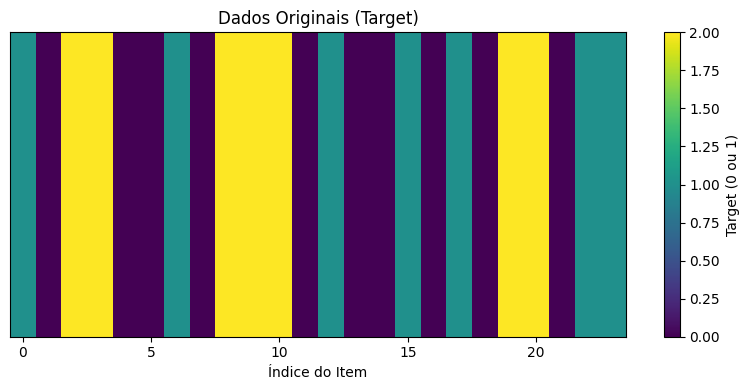

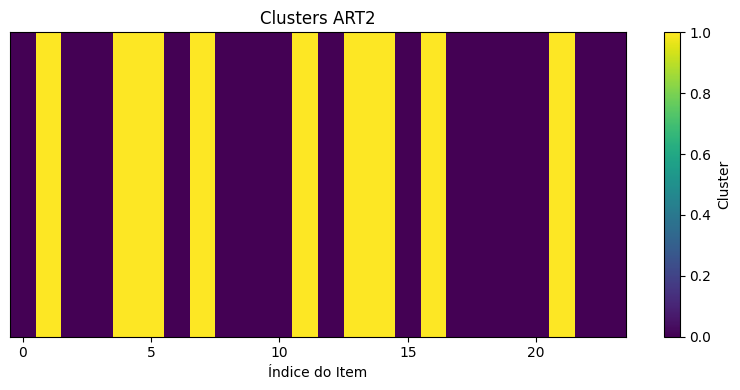

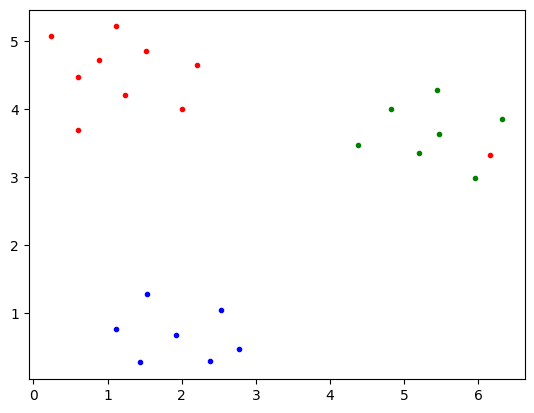

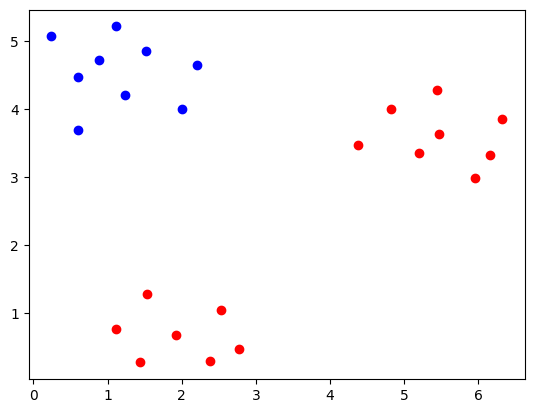

In [35]:
import random
import matplotlib.pyplot as plt

X = np.array([A,B,C,L,M,N,O,W,V,Z,D,Q,E,F,J,K,P,G,H,I,R,S,T,U])
y = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2])

X_temp = []
y_temp = []

for i in range(len(X)):
  i = random.randrange(len(X))
  X_temp.append(X[i])
  y_temp.append(y[i])
  X = np.delete(X, i, axis=0)
  y = np.delete(y, i, axis=0)

X = np.array(X_temp)
y = np.array(y_temp)

w = ART2(X, output=3, rho=0.9722)

plot_heatmap(y, 'Dados Originais (Target)')
plot_heatmap(w, 'Clusters ART2')

plt.figure(1)
color_list_point = ['r.','b.','g.']
color_list_circle = ['ro', 'bo', 'go']

for j in range(int(max(y))+1):
    plt.plot(X[abs(y-j)<e,0], X[abs(y-j)<e,1],color_list_point[j])
plt.figure(2)
for j in range(int(max(w))+1):
    plt.plot(X[abs(w-j)<e, 0], X[abs(w-j)<e, 1], color_list_circle[j])
plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ART2(nn.Module):
    def __init__(self, input_dim, num_categories, vigilance=0.9):
        """
        Initializes the ART2 model.

        Parameters:
        - input_dim (int): Dimensionality of the input data.
        - num_categories (int): Maximum number of categories the network can learn.
        - vigilance (float): Vigilance parameter (0 < vigilance <= 1) controlling similarity threshold.
        """
        super(ART2, self).__init__()
        self.input_dim = input_dim
        self.num_categories = num_categories
        self.vigilance = vigilance

        # Weights connecting layer F1 to F2 (input to categories)
        self.weights = torch.zeros((num_categories, input_dim))

        # Initialize weights with random values and normalize them
        self.weights = F.normalize(torch.rand((num_categories, input_dim)), p=2, dim=1)

    def forward(self, x):
        """
        Forward pass through the ART2 network.

        Parameters:
        - x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
        - category (int): The index of the matching category, or -1 if no match is found.
        """
        # Normalize the input vector
        x = F.normalize(x, p=2, dim=1)

        # Compute similarities (dot product)
        similarities = torch.matmul(self.weights, x.T)

        # Find the best matching category
        best_match = torch.argmax(similarities, dim=0).item()

        # Check the vigilance criterion
        if similarities[best_match].item() >= self.vigilance:
            # Update weights of the matched category
            self.weights[best_match] = F.normalize(
                self.weights[best_match] + x, p=2, dim=0
            )
            return best_match
        else:
            # If no match, return -1
            return -1

    def add_category(self, x):
        """
        Add a new category if no matching category exists.

        Parameters:
        - x (Tensor): Input tensor of shape (input_dim,).

        Returns:
        - category (int): Index of the newly created category, or -1 if capacity is full.
        """
        for i in range(self.num_categories):
            if torch.all(self.weights[i] == 0):  # Check for unused category
                self.weights[i] = F.normalize(x, p=2, dim=0)
                return i
        return -1  # No capacity left

    def reset_mechanism(self, x, best_match):
        """
        Implements the reset mechanism to verify if the best match meets the vigilance criteria.

        Parameters:
        - x (Tensor): Input tensor of shape (input_dim,).
        - best_match (int): Index of the best matching category.

        Returns:
        - bool: True if reset is required, False otherwise.
        """
        similarity = torch.dot(self.weights[best_match], x) / (torch.norm(self.weights[best_match]) * torch.norm(x))
        return similarity < self.vigilance

    def learn(self, x):
        """
        High-level method to process an input vector and perform learning.

        Parameters:
        - x (Tensor): Input tensor of shape (input_dim,).

        Returns:
        - category (int): Index of the category where the input was classified.
        """
        x = F.normalize(x, p=2, dim=0)  # Normalize the input
        similarities = torch.matmul(self.weights, x)
        best_match = torch.argmax(similarities).item()

        if not self.reset_mechanism(x, best_match):
            # Update weights if reset is not required
            self.weights[best_match] = F.normalize(
                self.weights[best_match] + x, p=2, dim=0
            )
            return best_match
        else:
            # Add a new category if reset is triggered
            return self.add_category(x)

    def test(self, dataset):
        """
        Test the ART2 network with a dataset and return classification results.

        Parameters:
        - dataset (Tensor): A tensor of shape (num_samples, input_dim).

        Returns:
        - results (list): A list of category indices for each input sample.
        """
        results = []
        for sample in dataset:
            category = self.learn(sample)
            results.append(category)
        return results

    def print_weights(self):
        """
        Print the current state of the weights for debugging purposes.
        """
        print("Current Weights:")
        print(self.weights)

# Metrics and Validation
def validate_model(model, dataset):
    """
    Validate the ART2 model by testing its classification performance.

    Parameters:
    - model (ART2): The ART2 model instance.
    - dataset (Tensor): A tensor of shape (num_samples, input_dim).

    Returns:
    - accuracy (float): Ratio of correctly classified samples (if labeled data is available).
    - categories_used (int): Number of categories effectively used by the model.
    """
    results = model.test(dataset)
    unique_categories = len(set(results))
    print("Categories used:", unique_categories)

    # Assuming labels are part of the dataset for validation
    # Here, we just print the categories for simplicity
    return unique_categories

# Example usage
def main():
    # Define input dimensions and categories
    input_dim = 4
    num_categories = 4
    vigilance = 0.8

    # Initialize ART2 network
    model = ART2(input_dim=input_dim, num_categories=num_categories, vigilance=vigilance)

    # Define a small dataset
    dataset = torch.tensor([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ])

    # Test the network
    results = model.test(dataset)
    print("Classification Results:", results)

    # Print weights
    model.print_weights()

    # Validate the model
    validate_model(model, dataset)

if __name__ == "__main__":
    main()


Classification Results: [-1, -1, 0, -1]
Current Weights:
tensor([[0.2228, 0.1492, 0.9630, 0.0263],
        [0.4418, 0.5587, 0.6792, 0.1772],
        [0.3297, 0.4981, 0.5793, 0.5546],
        [0.7475, 0.3534, 0.3619, 0.4306]])
Categories used: 2
